In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

# 1) Data Preprocessing ( Data Augmentation for Train Data for removing spatial invariance !! )

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.3,
    shear_range=0.3,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [3]:
Height =224
Width = 224
Channel = 3

In [19]:
train_data = train_datagen.flow_from_directory(
    "New_XRay_Dataset/Train",
    target_size=(Height,Width),
    batch_size=32,
    class_mode="binary"
)

val_data = val_datagen.flow_from_directory(
    "New_XRay_Dataset/Val",
    target_size=(Height,Width),
    batch_size=32,
    class_mode="binary"
)

test_data = test_datagen.flow_from_directory(
    "New_XRay_Dataset/Prediction",
    target_size=(Height,Width),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


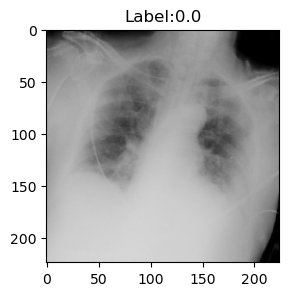

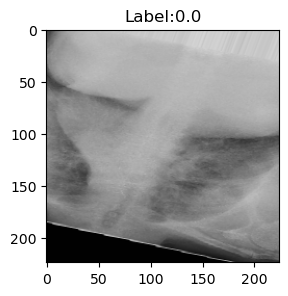

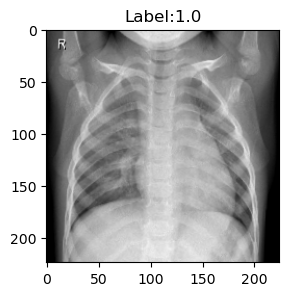

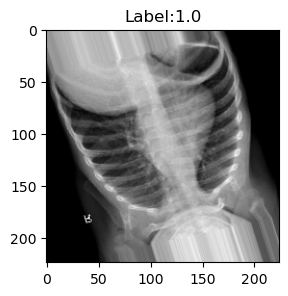

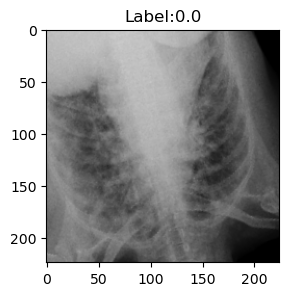

In [70]:
train_images,train_labels = next(train_data)
n = 5
for i in range(n):
    plt.figure(figsize=(3,4))
    plt.imshow(train_images[i])
    plt.title(f"Label:{train_labels[i]}")

# 2) Creating a ResNet-50 Model , with non-trainable layers

In [41]:
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(Height,Width,Channel),
    classes="binary",
    weights="imagenet"
)

for layer in resnet_model.layers:
    layer.trainable = False

# 3) Adding Resnet model to Sequential model and then adding Full Connection

In [42]:
model = tf.keras.models.Sequential()

model.add(resnet_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=64,activation="relu"))
model.add(tf.keras.layers.Dense(units=128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=64,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_26 (Dense)            (None, 64)                6422592   
                                                                 
 dense_27 (Dense)            (None, 128)               8320      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               33024     
                                                                 
 dropout_13 (Dropout)        (None, 256)              

In [44]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# 4) Training

In [45]:
history = model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=19)

Epoch 1/19
9/9 [==============================] - 31s 3s/step - loss: 1.0269 - accuracy: 0.4479 - val_loss: 0.7161 - val_accuracy: 0.5000
Epoch 2/19
9/9 [==============================] - 29s 3s/step - loss: 0.7495 - accuracy: 0.5451 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 3/19
9/9 [==============================] - 31s 3s/step - loss: 0.7118 - accuracy: 0.5174 - val_loss: 0.7082 - val_accuracy: 0.5000
Epoch 4/19
9/9 [==============================] - 30s 3s/step - loss: 0.6798 - accuracy: 0.6042 - val_loss: 0.6601 - val_accuracy: 0.5500
Epoch 5/19
9/9 [==============================] - 32s 4s/step - loss: 0.6398 - accuracy: 0.6424 - val_loss: 0.5787 - val_accuracy: 0.7500
Epoch 6/19
9/9 [==============================] - 28s 3s/step - loss: 0.5864 - accuracy: 0.7569 - val_loss: 0.4996 - val_accuracy: 0.8333
Epoch 7/19
9/9 [==============================] - 28s 3s/step - loss: 0.5277 - accuracy: 0.8333 - val_loss: 0.6013 - val_accuracy: 0.7667
Epoch 8/19
9/9 [==================

In [58]:
def display_History(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epoch = range(1,len(acc)+1)
    
    fig,axes = plt.subplots(1,2,figsize=(16,7),dpi=179)
    axes[0].plot(epoch,acc,"o--",label="Train Accuracy")
    axes[0].plot(epoch,val_acc,"rD:",label="Validation Accuracy")
    axes[0].set_xlabel("Epochs",fontsize=19)
    axes[0].set_ylabel("Accuracy",fontsize=19)
    axes[0].set_title("Accuracy vs Epochs",fontsize=19)
    axes[0].legend()
    
    
    axes[1].plot(epoch,loss,"o--",label="Train Loss")
    axes[1].plot(epoch,val_loss,"rD:",label="Validation Loss")
    axes[1].set_xlabel("Epochs",fontsize=19)
    axes[1].set_ylabel("Loss",fontsize=19)
    axes[1].set_title("Loss vs Epochs",fontsize=19)
    axes[1].legend()

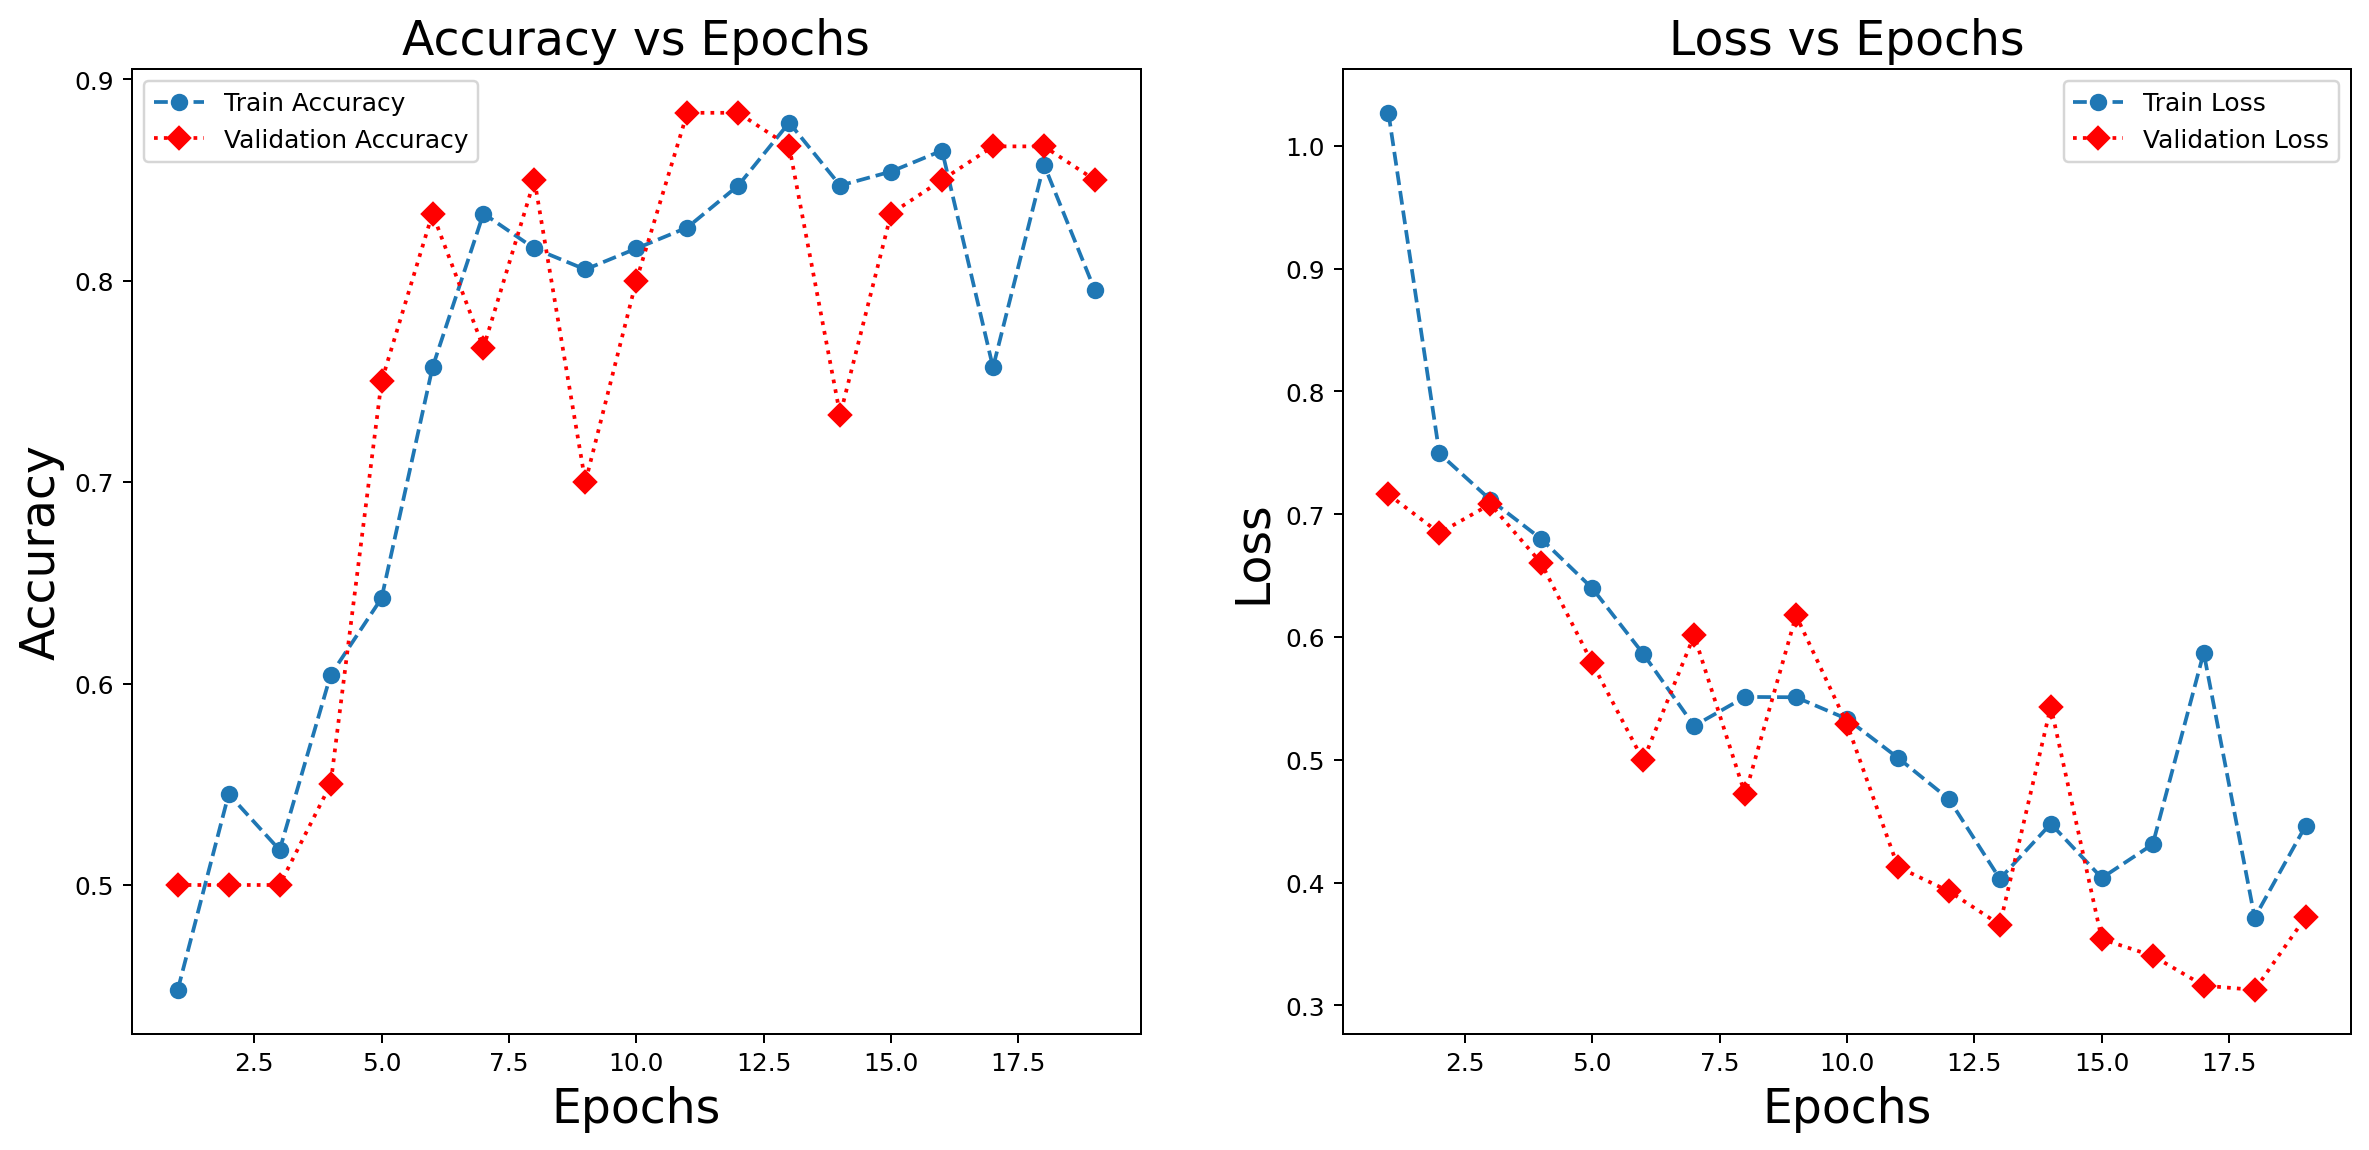

In [59]:
display_History(history)

In [51]:
model.evaluate(train_data)

9/9 [==============================] - 24s 3s/step - loss: 0.3238 - accuracy: 0.9028


[0.32384616136550903, 0.9027777910232544]

In [52]:
model.evaluate(val_data)

2/2 [==============================] - 5s 2s/step - loss: 0.3718 - accuracy: 0.8500


[0.37182995676994324, 0.8500000238418579]

In [53]:
model.evaluate(test_data)

2/2 [==============================] - 4s 2s/step - loss: 0.2022 - accuracy: 0.9811


[0.2022412121295929, 0.9811320900917053]

In [54]:
y_pred = [1 if val > 0.5 else 0 for val in model.predict(test_data)]

2/2 [==============================] - 6s 2s/step


In [55]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [56]:
train_data.class_indices

{'Covid': 0, 'Normal': 1}

# 5) Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.97      0.98        32

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53



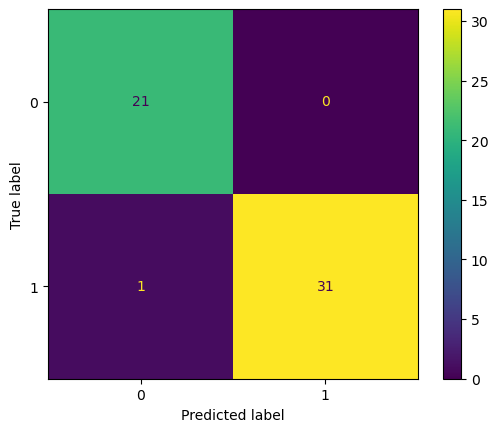

In [64]:
print(classification_report(test_data.labels,y_pred))
d = ConfusionMatrixDisplay(confusion_matrix(test_data.labels,y_pred))
d.plot();